In [11]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
task = 6
binary=True
if binary:
    results_folder = "/cephyr/users/adambre/Alvis/mnist_transfer/results/task"+str(task)+"/Binary"
else:
    results_folder = "/cephyr/users/adambre/Alvis/mnist_transfer/results/task"+str(task)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
r_files = [f for f in os.listdir(results_folder) if ('results.pkl' in f and not 'prior_results.pkl' in f)]

D = pd.DataFrame({})

for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0,sort=False)
    
D['germain_bound'] = np.nan
D['beta_bound'] = np.nan

D = D.sort_values(by=[ 'alpha','Weightupdates', 'sigma'])#

D.head(20)

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,sigma,epsilon,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound
0,660.0,0.034419,0.034480,108879.842810,0.029330,0.029469,0.010023,0.010178,0.006760,0.006728,...,0.003,0.1,1_660,0.05,167884,167884,10,69105,NaN,NaN
0,660.0,0.002863,0.002854,10930.674644,0.000027,0.000021,0.005667,0.005672,0.008954,0.009172,...,0.030,0.1,1_660,0.05,167884,167884,10,69105,NaN,NaN
0,660.0,0.355488,0.354961,1091.278153,0.144119,0.143585,0.422751,0.422739,0.401992,0.402139,...,0.300,0.1,1_660,0.05,167884,167884,10,69105,NaN,NaN
0,792.0,0.120173,0.119401,109738.090743,0.112691,0.111833,0.015135,0.014964,0.010229,0.010418,...,0.003,0.1,1_792,0.05,167884,167884,10,69105,NaN,NaN
0,792.0,0.026496,0.026297,10908.052743,0.004055,0.003957,0.044680,0.044883,0.039644,0.039471,...,0.030,0.1,1_792,0.05,167884,167884,10,69105,NaN,NaN
0,792.0,0.493088,0.492624,1090.486663,0.201195,0.200900,0.583448,0.583785,0.388548,0.388392,...,0.300,0.1,1_792,0.05,167884,167884,10,69105,NaN,NaN
0,924.0,0.003721,0.003428,109001.525642,0.003016,0.002733,0.001389,0.001411,0.001160,0.001143,...,0.003,0.1,1_924,0.05,167884,167884,10,69105,NaN,NaN
0,924.0,0.000698,0.000689,10923.842154,0.000003,0.000004,0.001372,0.001389,0.001804,0.001804,...,0.030,0.1,1_924,0.05,167884,167884,10,69105,NaN,NaN
0,924.0,0.414738,0.414479,1086.166029,0.130879,0.130875,0.567207,0.567718,0.412220,0.412219,...,0.300,0.1,1_924,0.05,167884,167884,10,69105,NaN,NaN
0,1056.0,0.041491,0.041670,109756.950654,0.036743,0.037126,0.009090,0.009496,0.005738,0.005453,...,0.003,0.1,1_1056,0.05,167884,167884,10,69105,NaN,NaN


In [13]:
m_bound = D['m_bound'].values[0]
delta = D['delta'].values[0]
"""
###### average over all seeds
new_df=pd.DataFrame({})

for a in [0,0.3]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in np.sort(D['epsilon'].unique()): 
            for w in np.sort(D['Weightupdates'].unique()):
                stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)&(D['Weightupdates']==w)
                if(len(D[stratum])>=2):
                    print(D[stratum])
sys.exit(-1)


### take 
"""
 # calculate disrho bound

for a in [0,0.1]:#,0.3,0.5,0.7,0.9]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in np.sort(D['epsilon'].unique()):         
            stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)#

            if(len(D[stratum])==0):
                print(a)
                print(s)
                print(e)
            else:
                train_germain = D[stratum]['train_germain'].values
                e_s = D[stratum]['e_s'].values
                e_t = D[stratum]['e_t'].values
                d_tx = D[stratum]['d_tx'].values
                d_sx = D[stratum]['d_sx'].values
                KL = D[stratum]['KL'].values

                res, bestparam, boundparts = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL))
                res_inf, _, _ = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL))

                # calculate beta bound
                [res2, bestparam2, boundparts2] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL),beta_bound=True)
                [res2_inf, _, _] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL),beta_bound=True)

                D.loc[stratum,'germain_bound'] = res
                D.loc[stratum,'beta_bound'] = res2
                D.loc[stratum,'germain_bound_inf'] = res_inf
                D.loc[stratum,'beta_bound_inf'] = res2_inf
                A=np.zeros(len(res))
                A[0]=bestparam[0]
                A[1]=bestparam[1]
                A[2]=bestparam2[0]
                A[3]=bestparam2[1]
                ## saves disrho bound params first and then beta bound; a,omega
                D.loc[stratum,'params'] = A



Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....


,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf,params
0,660.0,0.034419,0.034480,108879.842810,0.029330,0.029469,0.010023,0.010178,0.006760,0.006728,...,0.05,167884,167884,10,69105,2.954331,17.561889,0.034894,0.327314,0.80
0,660.0,0.002863,0.002854,10930.674644,0.000027,0.000021,0.005667,0.005672,0.008954,0.009172,...,0.05,167884,167884,10,69105,0.532780,1.579620,0.003122,0.003129,0.30
0,660.0,0.355488,0.354961,1091.278153,0.144119,0.143585,0.422751,0.422739,0.401992,0.402139,...,0.05,167884,167884,10,69105,0.562579,2.937955,0.356367,1.795127,0.13
0,792.0,0.120173,0.119401,109738.090743,0.112691,0.111833,0.015135,0.014964,0.010229,0.010418,...,0.05,167884,167884,10,69105,3.404703,23.213740,0.121397,1.245918,5.00
0,792.0,0.026496,0.026297,10908.052743,0.004055,0.003957,0.044680,0.044883,0.039644,0.039471,...,0.05,167884,167884,10,69105,0.639816,2.117098,0.026953,0.066916,4.50
0,792.0,0.493088,0.492624,1090.486663,0.201195,0.200900,0.583448,0.583785,0.388548,0.388392,...,0.05,167884,167884,10,69105,0.721736,3.983969,0.493926,2.502705,0.30
0,924.0,0.003721,0.003428,109001.525642,0.003016,0.002733,0.001389,0.001411,0.001160,0.001143,...,0.05,167884,167884,10,69105,2.802357,15.805916,0.004266,0.033835,6.00
0,924.0,0.000698,0.000689,10923.842154,0.000003,0.000004,0.001372,0.001389,0.001804,0.001804,...,0.05,167884,167884,10,69105,0.522708,1.565216,0.000957,0.000719,10.00
0,924.0,0.414738,0.414479,1086.166029,0.130879,0.130875,0.567207,0.567718,0.412220,0.412219,...,0.05,167884,167884,10,69105,0.630529,2.801633,0.415351,1.721886,0.90
0,1056.0,0.041491,0.041670,109756.950654,0.036743,0.037126,0.009090,0.009496,0.005738,0.005453,...,0.05,167884,167884,10,69105,3.008776,18.173531,0.042337,0.408306,8.00


Sigma = 0.00300 Alpha = 0.00000 Epsilon = 0.10000


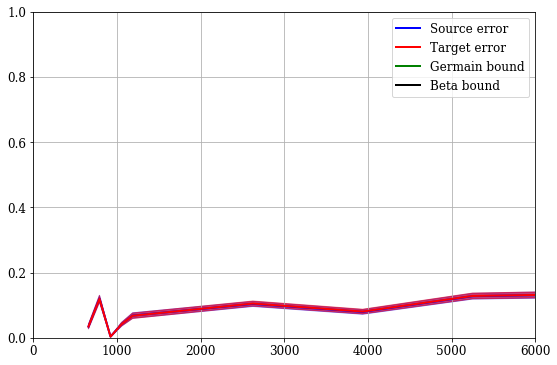

Sigma = 0.03000 Alpha = 0.00000 Epsilon = 0.10000


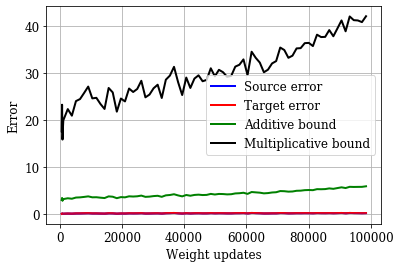

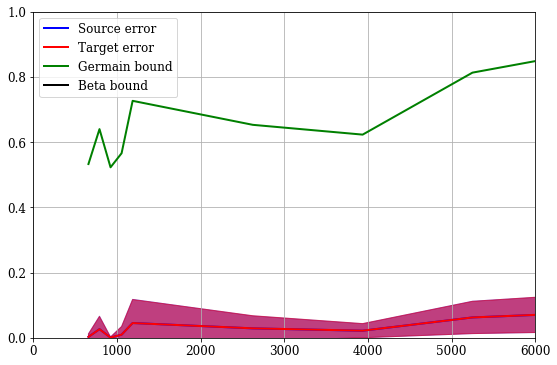

Sigma = 0.30000 Alpha = 0.00000 Epsilon = 0.10000


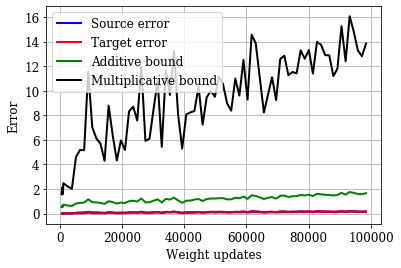

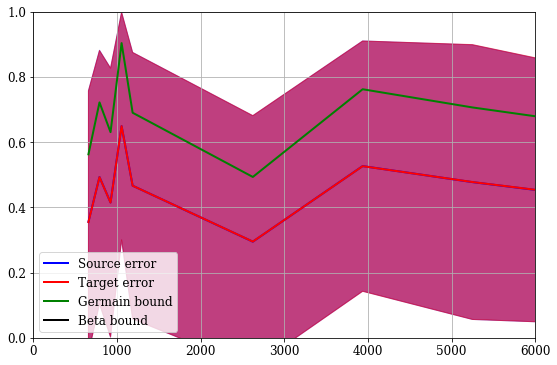

Sigma = 0.00300 Alpha = 0.10000 Epsilon = 0.10000


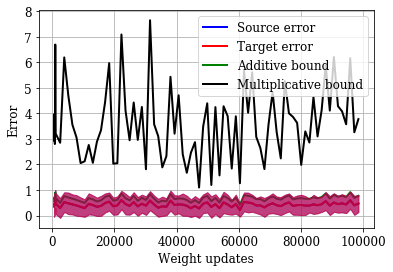

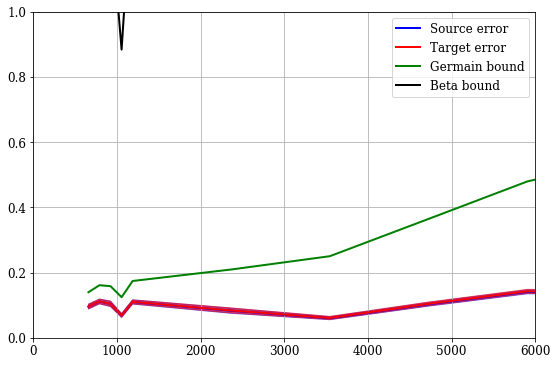

Sigma = 0.03000 Alpha = 0.10000 Epsilon = 0.10000


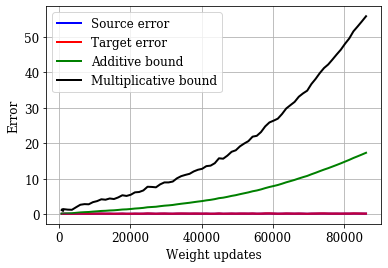

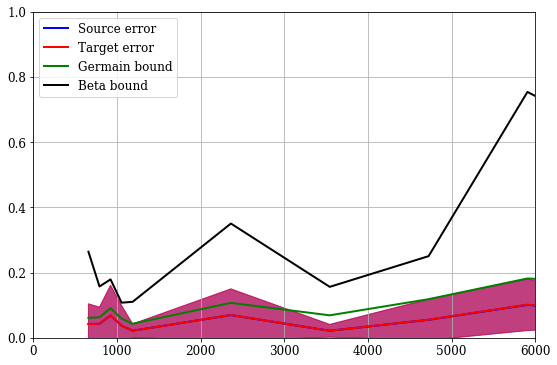

Sigma = 0.30000 Alpha = 0.10000 Epsilon = 0.10000


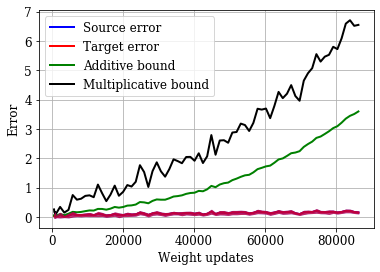

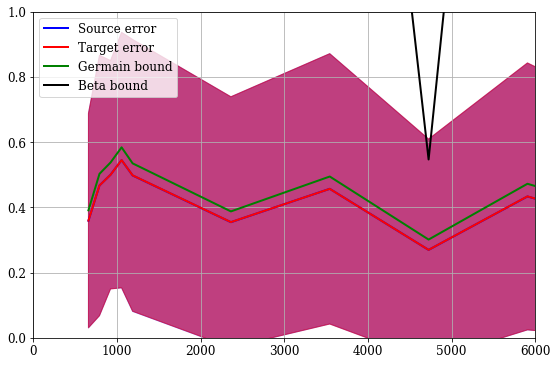

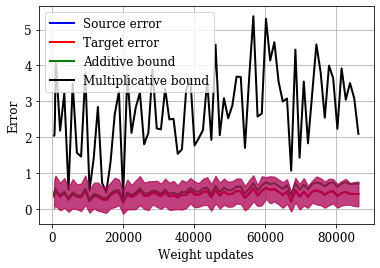

In [22]:
#plt.rc('font', size=16, family='serif')
display(D.head(10))
plt.rc('font', size=12, family='serif')
#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in [0,0.1]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in [0.1]:#np.sort(D['epsilon'].unique()):
            print('Sigma = %.5f' % s, 'Alpha = %.5f' % a,'Epsilon = %.5f' % e)

            stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)

            ws = D[stratum]['Weightupdates']
            e_so = D[stratum]['train_germain']
            e_ta = D[stratum]['target_germain']
            e_so_std = D[stratum]['error_std']
            e_ta_std = D[stratum]['target_error_std']
            e_t= D[stratum]['e_t']
            e_s= D[stratum]['e_s']
            d_tx= D[stratum]['d_tx']
            d_sx= D[stratum]['d_sx']
            KL = D[stratum]['KL']
            gb = D[stratum]['germain_bound']
            bb = D[stratum]['beta_bound']       
            
            plt.figure(figsize=(9,6))
            plt.grid(zorder=-100)

            plt.plot(ws, e_so, label='Source error', lw=2, c='b')
            plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')

            plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
            plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')

            plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
            plt.plot(ws, bb, label='Beta bound', lw=2, c='k')

            plt.xlim(0, 6000)
            plt.ylim(0, 1.)
            plt.legend()
            plt.show()
             #plot_amount_of_bound
    
            #just calculate the bound for each stratum and then plot the resulting proportions in a plot
        #### disrho
            plt.clf()
            plt.grid(zorder=-100)
            
            m=D[stratum]['m_bound'].values[0]
            m_t=D[stratum]['m_target'].values[0]
            alp=D[stratum]['params'].values[0]
            omega=D[stratum]['params'].values[1]
            L=len(D[stratum])
            bound=[]
            aprime=2*alp/(1-np.exp(-2*alp))
            omegaprime=omega/(1-np.exp(-omega))
            a1=np.zeros(L)
            a2=np.zeros(L)
            a3=np.zeros(L)
            a4=np.zeros(L)
            a5=np.zeros(L)
            for i in range(L):
                dis_rho=np.abs(e_t.values[i]-e_s.values[i])
                lambda_rho=np.abs(d_tx.values[i]-d_sx.values[i])
                a1[i]=omegaprime*e_so.values[i]
                a2[i]=aprime/2*(dis_rho)
                a3[i]=(omegaprime/omega+aprime/alp)*(KL.values[i]+np.log(3/delta))/m
                a4[i]=lambda_rho
                a5[i]=(aprime-1)/2
                bound.append(a1[i]+a2[i]+a3[i]+a4[i]+a5[i])
            plt.plot(ws,a1/bound)
            plt.plot(ws,a2/bound)
            plt.plot(ws,a3/bound)
            plt.plot(ws,a4/bound)
            plt.plot(ws,a5/bound)
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend(["Source error",r'Dis$_\rho$','KL',r'$\lambda_\rho$',"Constant"])
            #plt.show()
            #plt.savefig("disrho_portion_"+str(a)+".pdf")
            #sys.exit(-1)
        ### beta
            plt.clf()
            plt.grid(zorder=-100)
            #plt.rc('font', size=12, family='serif')
            #plt.clearfig
            BETA=10.986111
            beta_bound=[]
            b=D[stratum]['params'].values[2]
            c=D[stratum]['params'].values[3]
            bprime=BETA*b/(1-np.exp(-b))
            cprime=c/(1-np.exp(-c))
            a1=np.zeros(L)
            a2=np.zeros(L)
            a3=np.zeros(L)
            for i in range(L):
                a1[i]=cprime/2*(d_tx.values[i])
                a2[i]=bprime*e_s.values[i]
                a3[i]=(cprime/(m_t*c)+bprime/(m*b))*(2*KL.values[i]+np.log(2/delta))
                beta_bound.append(a1[i]+a2[i]+a3[i])
            plt.plot(ws,a1/beta_bound)
            plt.plot(ws,a2/beta_bound)
            plt.plot(ws,a3/beta_bound)
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend([r'$d_{tx}$',r'$e_s$','KL'])
            #plt.show()
            #plt.savefig("beta_portion_"+str(a)+".pdf")
            plt.clf()
            ##### end of proportions plot
            
            
           
            #plt.figure(figsize=(9,6))
            plt.grid(zorder=-100)
            #plt.rc('font', size=12, family='serif')
            plt.plot(ws, e_so, label='Source error', lw=2, c='b')
            plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=100, color='b')

            plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
            plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=100, color='r')

            plt.plot(ws, gb, label=r'Additive bound', lw=2, c='g')
            plt.plot(ws, bb, label='Multiplicative bound', lw=2, c='k')
            plt.xlabel("Weight updates")
            plt.ylabel("Error")
            #if a==0:
            #    plt.title(r'No data, $\alpha=0$')
            #else:
            #    plt.title(r'$\alpha=$'+str(a))
            plt.legend()
            #plt.show()
            #plt.savefig("result_"+str(a)+".pdf")

In [ ]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

        stratum = (D['sigma']==s)&(D['alpha']==a)
        ws = D[stratum]['Weightupdates']
        e_so = D[stratum]['train_germain']
        e_ta = D[stratum]['target_germain']
        e_so_std = D[stratum]['error_std']
        e_ta_std = D[stratum]['target_error_std']
        KL = D[stratum]['KL']
        gb = D[stratum]['germain_bound']
        gbi = D[stratum]['germain_bound_inf']
        bb = D[stratum]['beta_bound']       
        bbi = D[stratum]['beta_bound_inf']       

        plt.figure(figsize=(9,6))
        plt.grid(zorder=-100)

        plt.plot(ws, e_so, label='Source error', lw=2)    
        plt.plot(ws, e_ta, label='Target error', lw=2)    
        plt.plot(ws, gb, label='Germain bound', lw=2)
        plt.plot(ws, gbi, label='Germain bound (m=inf)', lw=2)
        plt.plot(ws, bb, label='Beta bound', lw=2)
        plt.plot(ws, bbi, label='Beta bound (m=inf)', lw=2)
        plt.xlim(0, 8000)
        plt.ylim(0, 1)

        plt.legend()
        plt.show()